# 7.2 케라스 콜백과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

## 7.2.1 콜백을 사용하여 모델의 훈련 과정 제어하기
- 적절한 에포크 횟수를 제어할 수 있는 방법
- 콜백을 사용하는 사례
    - **모델 체크포인트 저장** : 훈련하는 동안 어떤 지점에서 모델의 현재 가중치를 저장
    - **조기 종료**(early stopping) : 검증 손실이 더 이상 향상되지 않을 때 훈련을 중지
        - 훈련하는 동안 얻은 가장 좋은 모델을 저장
    - **훈련하는 동안 하이퍼파라미터 값을 동적으로 조정** : 옵티마이저의 학습률 등
    - **훈련과 검증 지표를 로그에 기록하거나 모델이 학습한 표현이 업데이트될 때마다 시각화** : 진행 표시줄 등
- `tensorflow.keras.callbacks` 모듈
    - `ModelCheckpoint`
    - `EarlyStopping`
    - `LearningRateScheduler`
    - `ReduceLROnPlateau`
    - `CSVLogger`
    - `History`
    - `BaseLogger`
    - `ProgbarLogger` 등

### ModelCheckpoint와 EarlyStopping 콜백
- `EarlyStopping` : 정해진 에포크 동안 모니터링 지표가 향상되지 않을 때 훈련을 중지
- `ModelCheckpoint` : 지금까지 가장 좋은 모델만 저장

In [ ]:
import tensorflow.keras as keras

# fit() 메서드의 callbacks 매개변수를 사용하여 콜백의 리스트를 모델로 전달
callbacks_list = [
    
    # 성능 향상이 멈추면 훈련을 중지
    keras.callbacks.EarlyStopping(
        moniter='val_accuracy', # 모델의 검증 정확도를 모니터링, 기본값은 val_loss
        patience=1, # 1 에포크보다 더 길게(= 2 에포크 동안) 정확도가 향상되지 않으면 훈련 중지
    ),
    
    # 에포크마다 현재 가중치를 저장
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5', # 모델 파일의 경로
        
        # val_loss가 좋아지지 않으면 모델 파일을 덮어쓰지 않음
        moniter='val_loss',
        save_best_only=True,
    )
]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy']) # 정확도를 모니터링 하므로 모델 지표에 포함되어야 함

# 콜백이 검증 손실과 검증 정확도를 모니터링하기 때문에 validation data가 있어야 함
model.fit(x, y, 
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

### ReduceLROnPlateau 콜백
- 검증 손실이 향상되지 않을 때 학습률을 작게 할 수 있음
- 학습률을 작게 하거나 크게 하면 훈련 도중 지역 최솟값에서 효과적으로 빠져나올 수 있음

In [ ]:
import tensorflow.keras as keras

callbacks_list = [
        keras.callbacks.ReduceLROnPlateau(
            moniter='val_loss', # 모델의 검증 손실을 모니터링
            factor=0.1, # 콜백이 호출될 때 학습률을 10배로 줄임
            patience=10, # 검증 손실이 10 에포크 동안 좋아지지 않으면 콜백 호출
        )
]

# 콜백이 검증 손실과 검증 정확도를 모니터링하기 때문에 validation data가 있어야 함
model.fit(x, y, 
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

### 자신만의 콜백 만들기
- `tensorflow.keras.callbacks.Callback` 클래스를 상속받아 구현
- `self.model` : 콜백을 호출하는 모델 객체
- `self.validation_data` : `fit()` 메서드에 전달된 검증 데이터

In [ ]:
import tensorflow.keras as keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    
    # 호출하는 모델에 대한 정보를 전달하기 위해 훈련하기 전에 호출
    def set_model(self, model):
        self.model = model
        layer_outputs = [layer.output for layer in modedl.layers]
        self.activations_model = keras.models.Model(model.input,
                                                    layers.outputs) # 각 층의 활성화 출력을 반환하는 Model 객체
        
    def on_epoch_end(self, epoch, logs=None): # 각 에포크가 끝날 때 호출
        if self.validation_data is None:
            raise RuntimeError('Requires validation data.')
            
        validation_sample = self.validation_data[0][0:1] # 검증 데이터의 첫 번째 샘플
        activations = self.activations_model.predict(validation_sample)
        # 배열을 저장
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'wb')
        np.savez(f, activations)
        f.close()

- `on_epoch_begin` : 각 에포크가 시작할 때 호출
- `on_epoch_end` : 각 에포크가 끝날 때 호출
- `on_batch_begin` : 각 배치 처리가 시작되기 전 호출
- `on_batch_end` : 각 배치 처리가 끝난 후 호출
- `on_train_begin` : 훈련이 시작될 때 호출
- `on_train_end` : 훈련이 끝날 때 호출

## 7.2.2 텐서보드 소개: 텐서플로의 시각화 프레임워크
- 좋은 모델을 개발하려면 모델 내부에서 어떤 일이 일어나는지 자주, 그리고 많은 피드백을 받아야함
- 발전 루프
    - 아이디어 > (딥러닝 프레임워크 : 텐서플로) > 실험 > (하드웨어 시스템) > 결과 > (시각화 프레임워크 : 텐서보드) > 아이디어 > ...
- 텐서보드
    - 훈련하는 동안 측정 지표를 시각적으로 모니터링
    - 모델 구조를 시각화
    - 활성화 출력과 그래디언트의 히스토그램을 그림
    - 3D로 임베딩을 표현

### 텐서보드를 사용한 텍스트 분류 모델
- 1D 컨브넷
- 어휘 사전에서 빈도가 높은 2000개 단어만 사용(단어 임베딩 시각화가 쉬움)

In [1]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000 # 특성으로 사용할 단어의 수
max_len = 500 # 사용할 텍스트의 길이

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

### 텐서보드를 사용하기 전에 로그 파일이 저장될 디렉터리 생성

In [6]:
import os

if not os.path.isdir('../my_log_dir/'):
    os.mkdir('../my_log_dir/')

### 텐서보드 콜백과 함께 모델 훈련하기

In [7]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='../my_log_dir/', # 로그 파일이 기록될 위치
        histogram_freq=1, # 1 에포크마다 활성화 출력의 히스토그램 기록
        embeddings_freq=1, # 1 에포크마다 임베딩 데이터를 기록
    )
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 6s 14ms/step - loss: 0.5930 - accuracy: 0.6890 - val_loss: 0.4578 - val_accuracy: 0.8304
Epoch 2/20
157/157 [==============================] - 2s 11ms/step - loss: 0.4328 - accuracy: 0.8561 - val_loss: 0.6819 - val_accuracy: 0.8050
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 0.3854 - accuracy: 0.8792 - val_loss: 0.5101 - val_accuracy: 0.8556
Epoch 4/20
157/157 [==============================] - 2s 11ms/step - loss: 0.3437 - accuracy: 0.9033 - val_loss: 0.9502 - val_accuracy: 0.8138
Epoch 5/20
157/157 [==============================] - 2s 11ms/step - loss: 0.2812 - accuracy: 0.9252 - val_loss: 0.5523 - val_accuracy: 0.8650
Epoch 6/20
157/157 [==============================] - 2s 11ms/step - loss: 0.2854 - accuracy: 0.9346 - val_loss: 0.6161 - val_accuracy: 0.8656
Epoch 7/20
157/157 [==============================] - 2s 11ms/step - loss: 0.2195 - accuracy: 0.9562 - val_loss: 0.7056 - val_accuracy: 0.8616

- 이후 anaconda prompt에서 `my_log_dir` 폴더가 있는 디렉터리로 이동한 후 `tensorboard --logdir=my_log_dir` 입력, http://localhost:6006 에 접속

▽ 측정 지표 모니터링
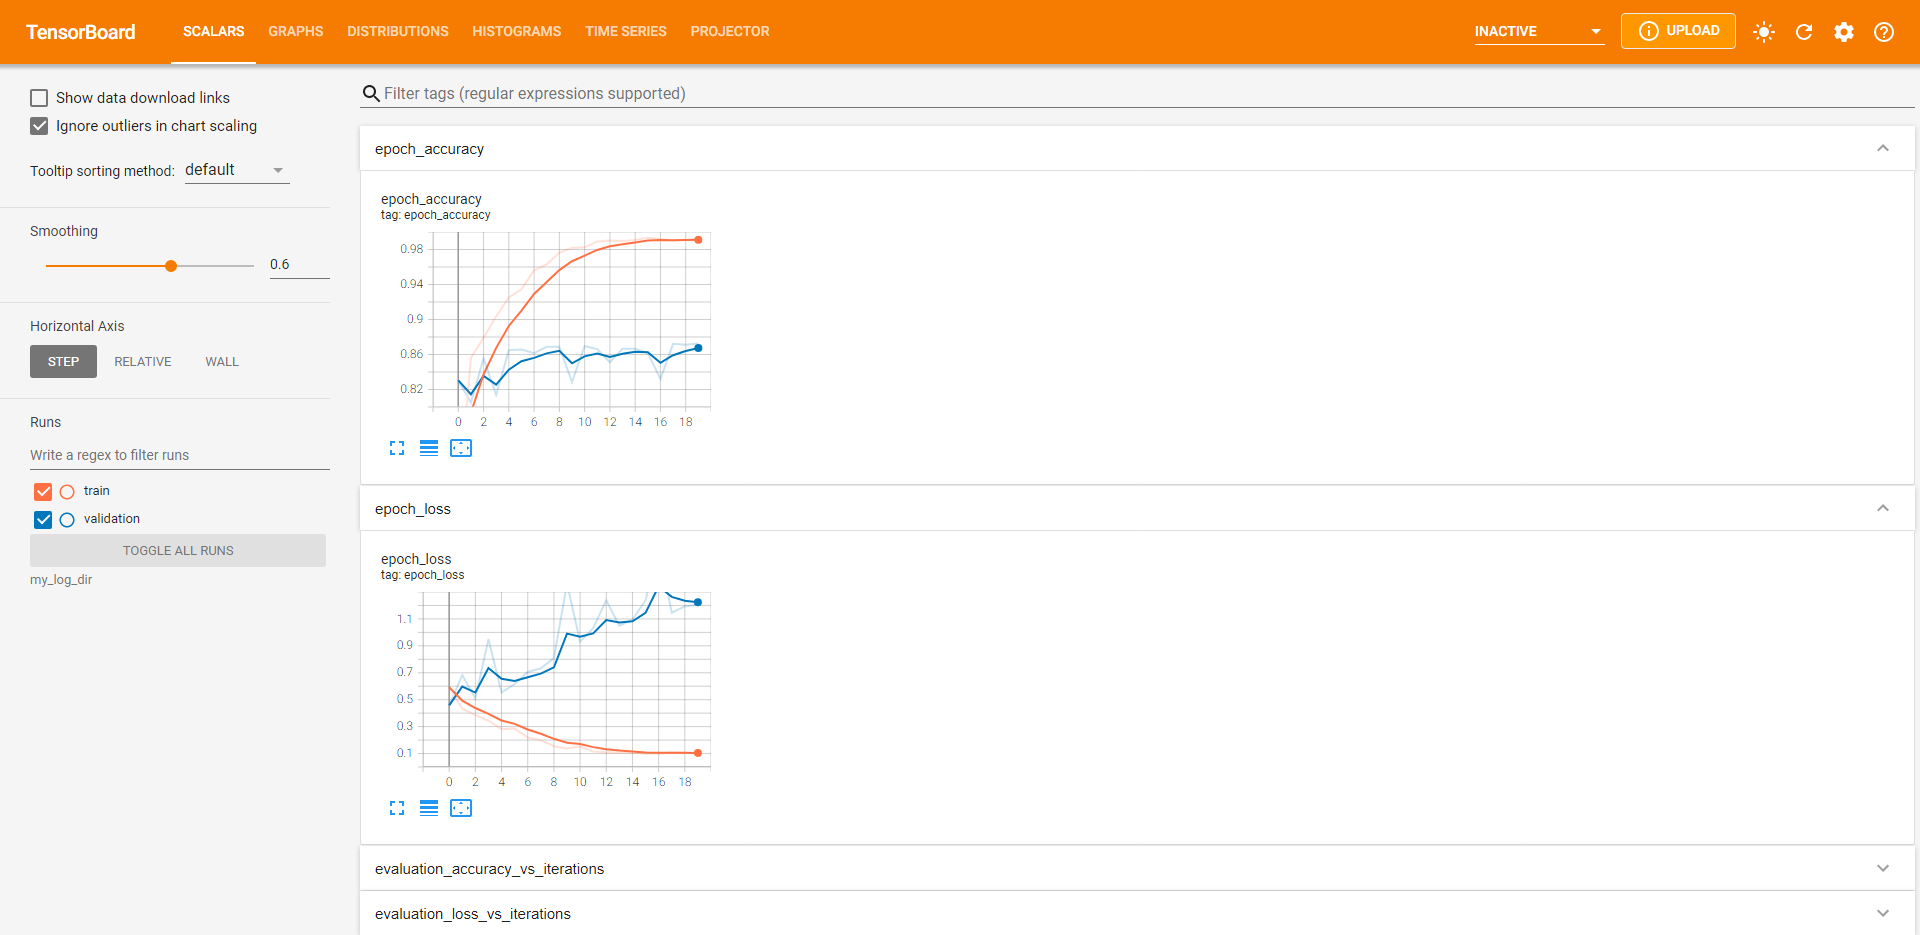

▽ 활성화 출력 히스토그램
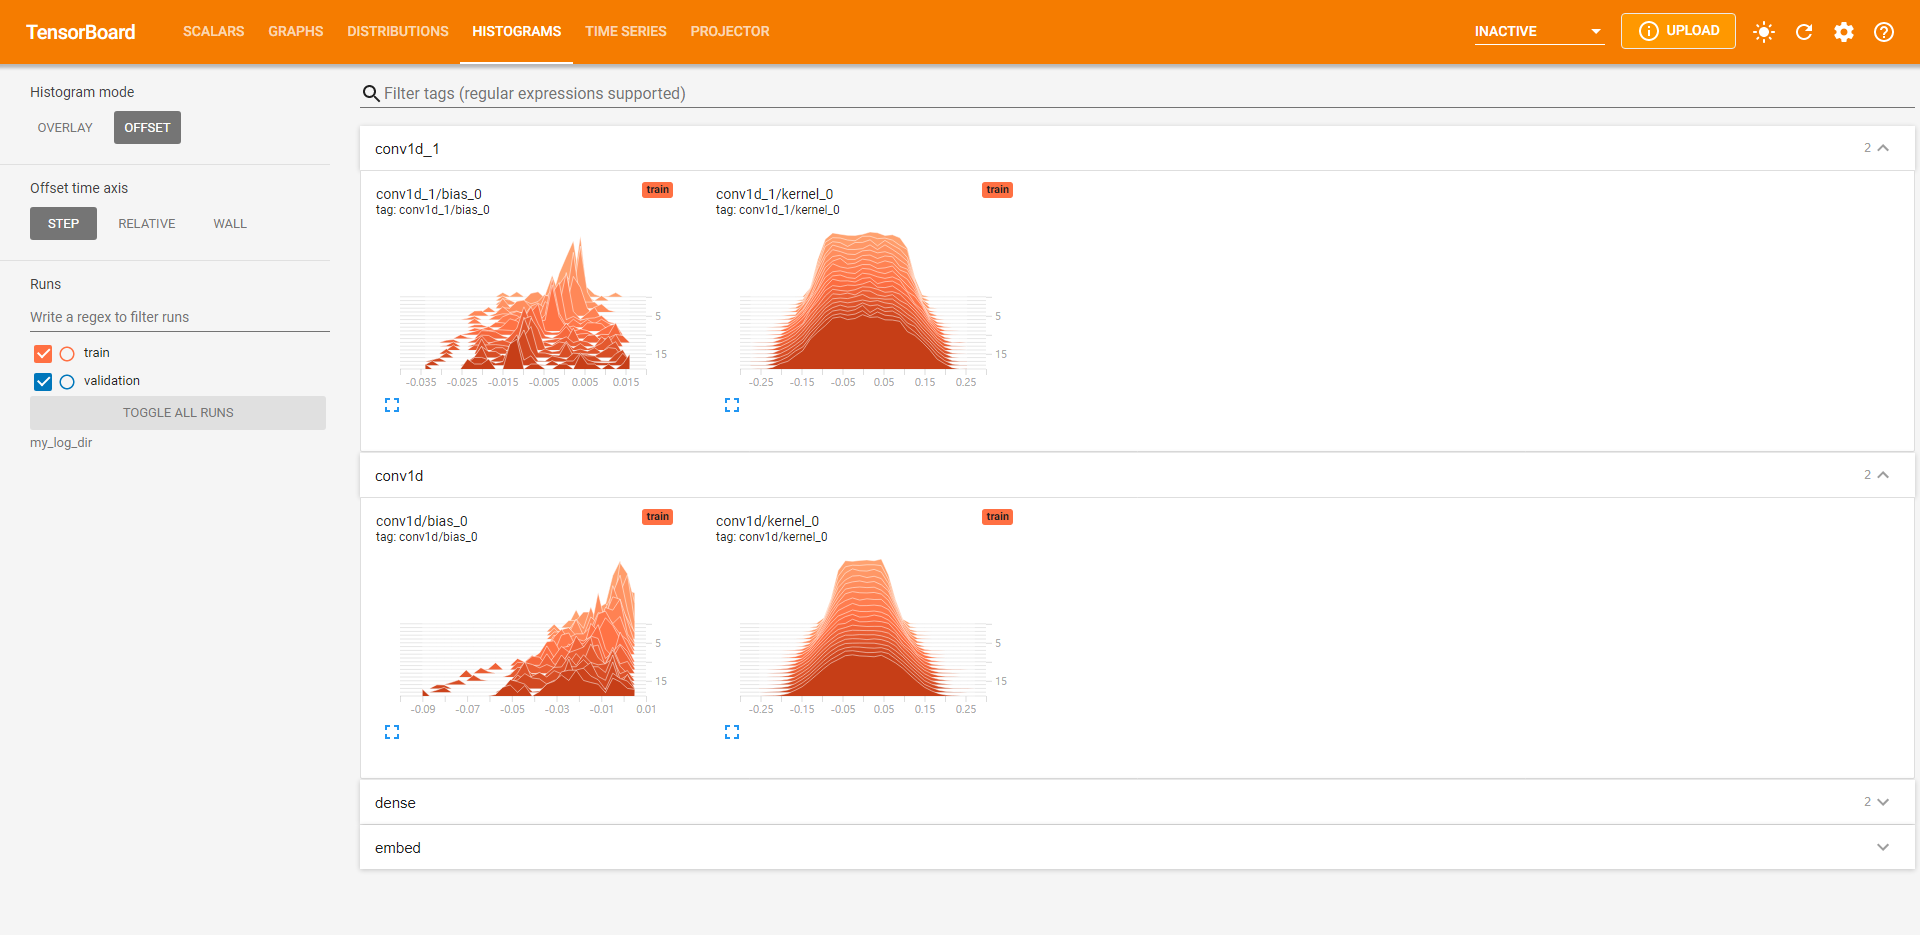

▽ 반응형 3D 단어 임베딩의 시각화
- 첫 번째 `Embedding` 층이 학습한 것을 PCA 또는 t-SNE로 2D 또는 3D로 축소하여 시각화
![반응형 3D 단어 임베딩의 시각화](tensorboard.gif)

▽ 텐서플로 그래프 시각화
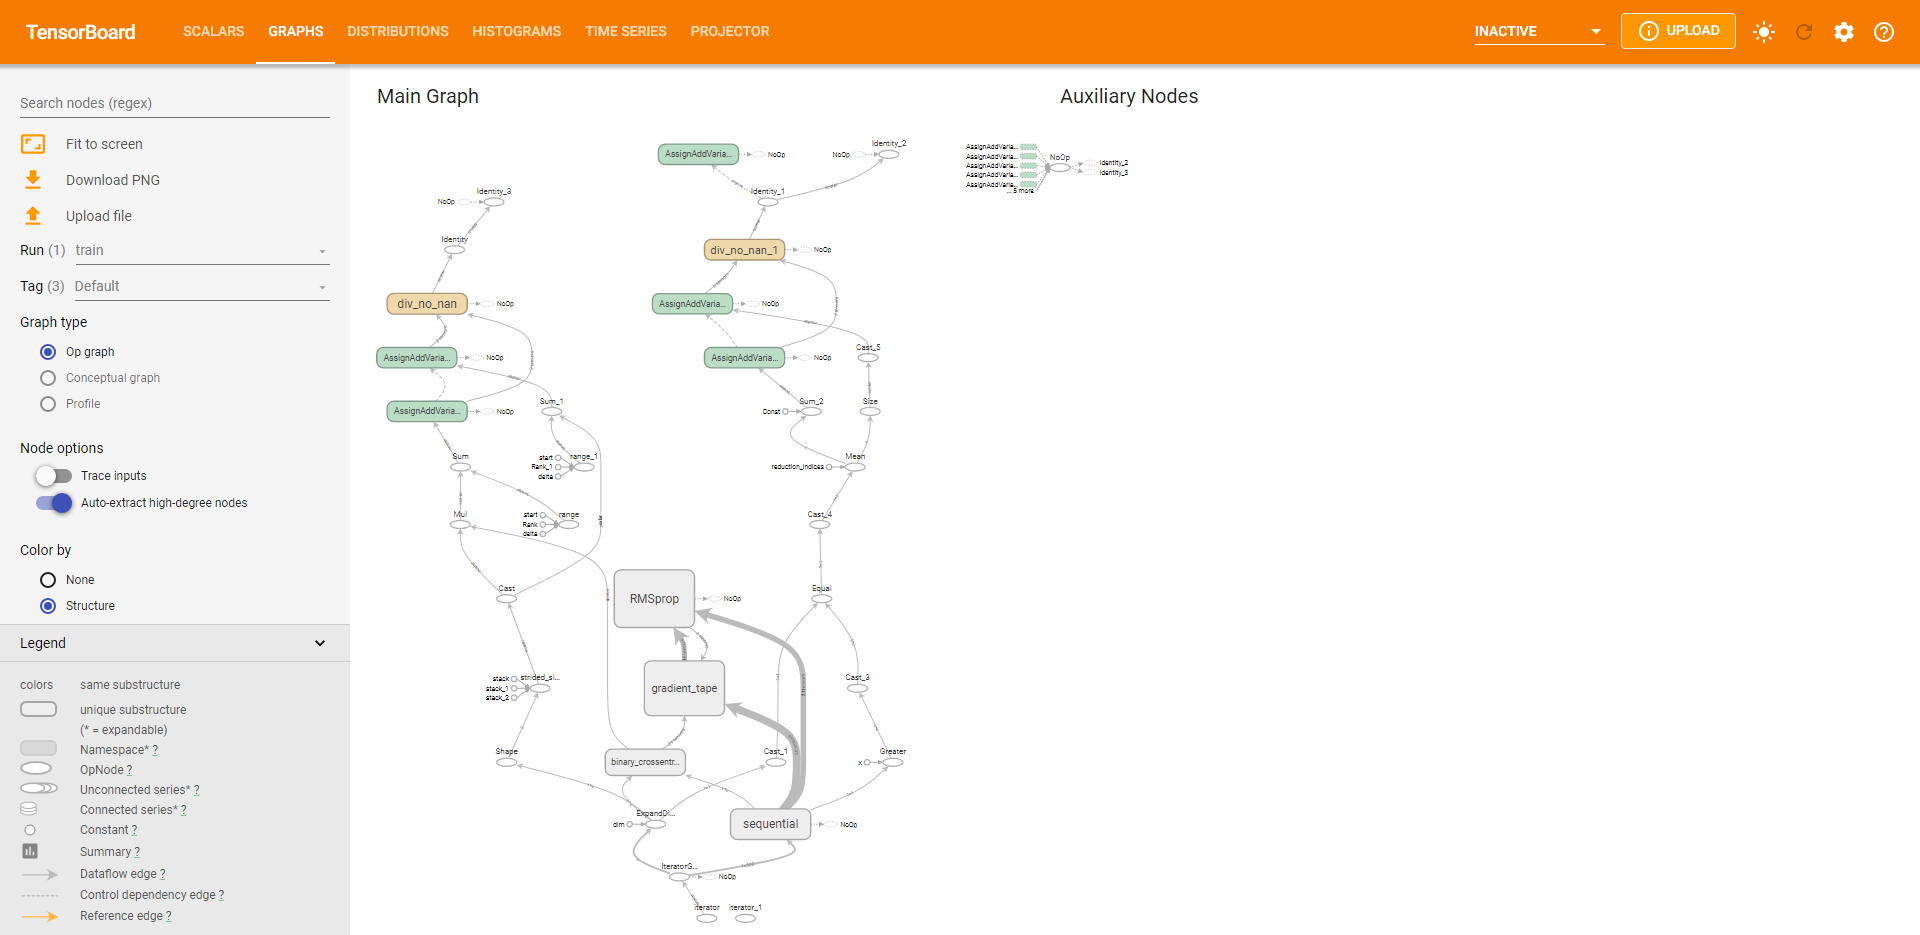

### 모델 그래프 그리기
- `pydot`과 `pydot-ng`, `graphviz` 라이브러리 필요

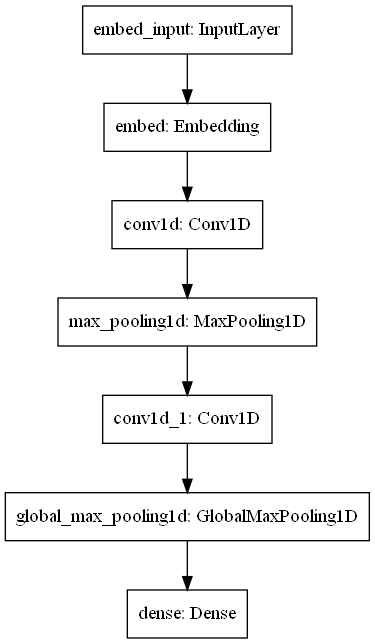

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')

### 층 그래프에 크기 정보를 추가

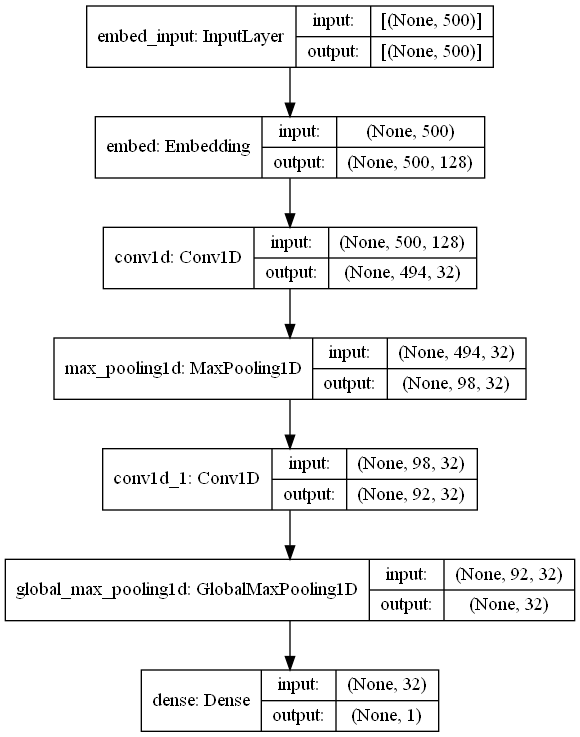

In [9]:
plot_model(model, show_shapes=True, to_file='model.png')